# Practical Assignment 2: Dependency Parsing

**Teams**: Pedro Guijas Bravo, Ángel Miguélez Millos.

**Due date**: December 18, 2022.

# 1. Imports

In [ ]:
import copy
import numpy as np
from os.path import exists
from matplotlib import pyplot as plt

from tensorflow.data import Dataset
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences, set_random_seed

# 2. ArcEager

## ArcEager Class

In [ ]:
class ArcEager:
  """
  Arc-eager algorithm (Section 4.2 from https://aclanthology.org/J08-4003.pdf).
  It works with indexes. Use [stack,buffer]_to_words method to check the words.
  """

  LA = "LEFT-ARC"
  RA = "RIGHT-ARC"
  REDUCE = "REDUCE"
  SHIFT = "SHIFT"

  def __init__(self):
    self.stack = None
    self.buffer = None
    self.dependencies = None
    self.sentence_len = None

  def set_initial_state(self, sentence_len):
    # [o,b,A] = [ [ROOT], [w1,w2,w3...], [] ]
    self.sentence_len = sentence_len
    self.stack = [0]
    self.buffer = list(range(1, sentence_len+1))
    self.dependencies = []

  def is_final_state(self):
    return self.buffer == []

  def has_head(self, el):
    return el in [x for (_,_,x) in self.dependencies]

  def valid_trans(self, trans):
    if trans == self.LA:
      # Head of the stack is not root (0) AND i have no head
      i = self.stack[0]
      return (i != 0) and (not self.has_head(i))

    elif trans == self.RA:
      # j have no parent
      j = self.buffer[0]
      return (not self.has_head(j))

    elif trans == self.REDUCE:
      # i have parent
      i = self.stack[0]
      return self.has_head(i)

    elif trans == self.SHIFT:
      return True

    else:
      return False

  def apply_trans(self, trans, l=None):
    if trans == self.LA:
      if l is None: raise(Exception(f"SPECIFY A RELATIONSHIP FOR THE {trans} OPERATION"))
      i = self.stack.pop(0)
      j = self.buffer[0]
      self.dependencies.append((j,l,i))

    elif trans == self.RA:
      if l is None: raise(Exception(f"SPECIFY A RELATIONSHIP FOR THE {trans} OPERATION"))
      i = self.stack[0]
      j = self.buffer.pop(0)
      self.stack.insert(0, j)
      self.dependencies.append((i,l,j))

    elif trans == self.REDUCE:
      self.stack.pop(0)

    elif trans == self.SHIFT:
      i = self.buffer.pop(0)
      self.stack.insert(0, i)

    else:
      raise(Exception(f"NON KNOWN TRANSITION ({trans})"))

  def stack_to_words(self, phrase, root_token="ROOT"):
    phrase = [root_token] + phrase
    return [phrase[x] for x in self.stack]

  def buffer_to_words(self, phrase):
    # Root cannot be in the buffer, but idx=0 is the ROOT, so add -1
    return [phrase[x-1] for x in self.buffer]

  def solve_errors(self, debug=False):
    # Rootless error
    root_childs = [(p,r,h) for (p,r,h) in self.dependencies if p == 0]
    els_with_parent = [h for (p,r,h) in self.dependencies]
    if root_childs == []:
      # Assign the root as the head of the first element without head
      for i in range(1, self.sentence_len+1):
        if i not in els_with_parent:
          if debug: print(f'WARNING! Rootless tree. Adding {(0,"root",i)} as the root child...')
          self.dependencies.append((0,"root",i))
          break

    # Root single child
    root_childs = [h for (p,_,h) in self.dependencies if p == 0]
    if len(root_childs) != 1:
      if debug: print(f"WARNING! Too many root childs: {root_childs}. Setting the head of the rest of childs to the first child...")
      main_child = root_childs[0]
      affected_child = root_childs[1:]
      self.dependencies = [((main_child,r,h) if h in affected_child else (p,r,h)) for (p,r,h) in self.dependencies]

    # Elements without parent
    root_childs = [h for (p,_,h) in self.dependencies if p == 0]
    els_with_parent = [h for (p,r,h) in self.dependencies]
    nodes_non_related = list(set(range(1, self.sentence_len+1)) - set(els_with_parent))
    new_rels = [(root_childs[0],'<unknown>',h) for h in nodes_non_related]
    if new_rels != [] and debug:
      print(f"WARNING! Elements without head found: {nodes_non_related}. Setting its head to {root_childs[0]}...")
    self.dependencies = self.dependencies + new_rels

  # No recursion problem because it is assumed a graph without cycles
  def pretty_print(self, phrase, n=0, rel="x", t=0):
    phrase = ["ROOT"] + phrase
    print('\t'*t + f"{n}. ({rel}) {phrase[n]}")
    [self.pretty_print(phrase[1:],n=h,rel=r,t=t+1) for (p,r,h) in self.dependencies if p==n]

  def phrase_dependences_to_arc_eager(dependencies):
      confs_and_actions = []
      arceager = ArcEager()
      arceager.set_initial_state(len(dependencies))

      dependencies = {(p,h):r for (p,r,h) in dependencies}

      while not arceager.is_final_state():
        s,b = arceager.stack[0], arceager.buffer[0]

        if arceager.valid_trans(ArcEager.LA) and (b,s) in dependencies:
          l = dependencies[(b,s)]
          confs_and_actions.append((copy.deepcopy(arceager), (ArcEager.LA, l)))
          arceager.apply_trans(ArcEager.LA, l=l)

        elif arceager.valid_trans(ArcEager.RA) and (s,b) in dependencies:
          l = dependencies[(s,b)]
          confs_and_actions.append((copy.deepcopy(arceager), (ArcEager.RA, l)))
          arceager.apply_trans(ArcEager.RA, l=l)

        elif arceager.valid_trans(ArcEager.REDUCE) and (s not in [b for (b,h) in dependencies.keys() if (h in arceager.buffer)]): # check no pending children
          confs_and_actions.append((copy.deepcopy(arceager), (ArcEager.REDUCE, "None")))
          arceager.apply_trans(ArcEager.REDUCE)

        else:
          confs_and_actions.append((copy.deepcopy(arceager), (ArcEager.SHIFT, "None")))
          arceager.apply_trans(ArcEager.SHIFT)

      # Return all the inter states
      return confs_and_actions

## ArcEager example test usage

In [ ]:

input = "Economic news had little effect on financial markets .".split()
output = [
    (2, 'nmod', 1),
    (3, 'subj', 2),
    (0, 'root', 3),
    (5, 'nmod', 4),
    (3, 'obj', 5),
    (5, 'nmod', 6),
    (8, 'nmod', 7),
    (6, 'pmod', 8),
    (3, 'p', 9)
]

states = ArcEager.phrase_dependences_to_arc_eager(output)

# Show intermediate states
for ae,a in states:
  print(f"stack: {ae.stack} buffer: {ae.buffer} action: {a}")
  print(f"\tstring_stack: {ae.stack_to_words(input)} \n\tstring_buffer: {ae.buffer_to_words(input)}")

# Print final state
print("\n ----------------------------FINAL STATE---------------------------- \n")
final_state = states[-1][0]
last_tran, last_rel = states[-1][1]
final_state.apply_trans(last_tran, l=last_rel)
final_state.pretty_print(input)

stack: [0] buffer: [1, 2, 3, 4, 5, 6, 7, 8, 9] action: ('SHIFT', 'None')
	string_stack: ['ROOT'] 
	string_buffer: ['Economic', 'news', 'had', 'little', 'effect', 'on', 'financial', 'markets', '.']
stack: [1, 0] buffer: [2, 3, 4, 5, 6, 7, 8, 9] action: ('LEFT-ARC', 'nmod')
	string_stack: ['Economic', 'ROOT'] 
	string_buffer: ['news', 'had', 'little', 'effect', 'on', 'financial', 'markets', '.']
stack: [0] buffer: [2, 3, 4, 5, 6, 7, 8, 9] action: ('SHIFT', 'None')
	string_stack: ['ROOT'] 
	string_buffer: ['news', 'had', 'little', 'effect', 'on', 'financial', 'markets', '.']
stack: [2, 0] buffer: [3, 4, 5, 6, 7, 8, 9] action: ('LEFT-ARC', 'subj')
	string_stack: ['news', 'ROOT'] 
	string_buffer: ['had', 'little', 'effect', 'on', 'financial', 'markets', '.']
stack: [0] buffer: [3, 4, 5, 6, 7, 8, 9] action: ('RIGHT-ARC', 'root')
	string_stack: ['ROOT'] 
	string_buffer: ['had', 'little', 'effect', 'on', 'financial', 'markets', '.']
stack: [3, 0] buffer: [4, 5, 6, 7, 8, 9] action: ('SHIFT', 'N

# 3. DependencyParser

## DependencyParser Class

In [ ]:
class DependencyParser():

  SUPPORTED_LANGUAGES = {
      "en":   ("UD_English-ParTUT", "en_partut-ud"),
  }

  def __init__(self, language="en", n=2, debug=False):
    self.n = n
    self.raw_train_ds, self.raw_dev_ds, self.raw_test_ds = None, None, None
    self.train_ds, self.dev_ds, self.test_ds = None, None, None
    self.model = None
    self.debug = debug

    # Tokenizers
    (self.word_tokenizer,self.pos_tags_tokenizer),(self.transitions_tokenizer,self.relation_tokenizer) = (None,None), (None,None)
    (self.num_words,self.num_post_tags),(self.num_transitions,self.num_relations) = (None,None), (None,None)

    # Initialize data
    self.language = None
    self.set_language(language)

  def set_language(self, language):
    # Check and load language info
    assert language in self.SUPPORTED_LANGUAGES, f"Only support the following languages: {list(lan for lan in self.SUPPORTED_LANGUAGES)}"
    print(f"\n> Language '{language}' selected")
    self.language = language
    dirname, base_filename = self.SUPPORTED_LANGUAGES[self.language]

    # Check if download
    for split in ("train", "dev", "test"):
      file = base_filename + "-" + split + ".conllu"
      if not exists(file):
        print(f"\tDownloading {split} file...")
        !wget https://github.com/UniversalDependencies/{dirname}/raw/master/{file} -q

    # Load raw data
    self.raw_train_ds = self._load_conllu(base_filename + "-train.conllu")
    self.raw_dev_ds = self._load_conllu(base_filename + "-dev.conllu")
    self.raw_test_ds = self._load_conllu(base_filename + "-test.conllu", remove_non_projective=False)

    if self.debug:
      print("  |Debug| Example of raw samples")
      print(f"\t- Input: {self.raw_train_ds[0][0]}")
      print(f"\t- Output: {self.raw_train_ds[1][0]}")

    # Preprocess samples
    print("\n> Preprocessing dataset")
    self.train_ds = self._preprocess_dataset(self.raw_train_ds)
    self.dev_ds   = self._preprocess_dataset(self.raw_dev_ds)
    self.test_ds  = self._preprocess_dataset(self.raw_test_ds)

    if self.debug:
      print("  |Debug| Example of final samples")
      print("\t- Inputs: (STACK AND BUFFER)")
      print(f"\t\t+ Stack Words: {self.train_ds[0][0][0]}")
      print(f"\t\t+ Buffer Words: {self.train_ds[0][1][0]}")
      print(f"\t\t+ Stack Pos Tags: {self.train_ds[0][2][0]}")
      print(f"\t\t+ Buffer Pos Tags: {self.train_ds[0][3][0]}")
      print("\t- Outputs:")
      print(f"\t\t+ Transition: {self.train_ds[1][0][0]}")
      print(f"\t\t+ Relation: {self.train_ds[1][1][0]}")

    # Encode data
    print("\n> Encoding dataset")
    self.train_ds, tokenizers = self._encode_dataset(self.train_ds)
    self.dev_ds, _            = self._encode_dataset(self.dev_ds, tokenizers=tokenizers)
    self.test_ds, _           = self._encode_dataset(self.test_ds, tokenizers=tokenizers)

    # Save tokenizers and num tokens
    (self.word_tokenizer,self.pos_tags_tokenizer),(self.transitions_tokenizer,self.relation_tokenizer) = tokenizers
    self.num_words        = len(self.word_tokenizer.word_index)
    self.num_post_tags    = len(self.pos_tags_tokenizer.word_index)
    self.num_transitions  = len(self.transitions_tokenizer.word_index)
    self.num_relations    = len(self.relation_tokenizer.word_index)

    assert len(self.train_ds[0][0][0]) == len(self.train_ds[0][1][0]) == len(self.train_ds[0][2][0]) == len(self.train_ds[0][3][0]) == self.n
    assert type(self.train_ds[1][0][0]) == type(self.train_ds[1][1][0]) == np.int64
    assert len(self.train_ds[0][0][0]) == len(self.dev_ds[0][0][0]) == len(self.test_ds[0][0][0])
    assert type(self.train_ds[1][0][0]) == type(self.dev_ds[1][0][0]) == type(self.test_ds[1][0][0])

    if self.debug:
      print("  |Debug| Example of final samples")
      print("\t- Inputs: (STACK AND BUFFER)")
      print(f"\t\t+ Stack Words: {self.train_ds[0][0][0]}")
      print(f"\t\t+ Buffer Words: {self.train_ds[0][1][0]}")
      print(f"\t\t+ Stack Pos Tags: {self.train_ds[0][2][0]}")
      print(f"\t\t+ Buffer Pos Tags: {self.train_ds[0][3][0]}")

      print("\t- Outputs:")
      print(f"\t\t+ Transition: {self.train_ds[1][0][0]}")
      print(f"\t\t+ Relation: {self.train_ds[1][1][0]}")

      print("  |Debug| Amount of samples:")
      print(f"\t\t+ Train: {self.train_ds[0][0].shape[0]} samples")
      print(f"\t\t+ Dev: {self.dev_ds[0][0].shape[0]} samples")
      print(f"\t\t+ Test: {self.test_ds[0][0].shape[0]} samples")

    print("\n> Building Dataset objects")
    self.train_ds = DependencyParser._to_dataset(self.train_ds)
    self.dev_ds = DependencyParser._to_dataset(self.dev_ds)
    self.test_ds = DependencyParser._to_dataset(self.test_ds)


  def _load_conllu(self, filename, remove_non_projective=True):
    dataset = ([], [])
    tmp_inputs = []
    tmp_outputs = []

    with open(filename) as f:
      for line in f:
        splitted_line = line.split()

        # End of phrase
        if splitted_line == []:

          # (parent, rel) -> (parent, rel, head)
          tmp_outputs = zip(range(1,len(tmp_outputs)+1), tmp_outputs)
          tmp_outputs = [(p,r,h) for (h,(p,r)) in tmp_outputs]

          # Add only projective sentences
          if DependencyParser.__is_projective([(p,h) for (p,r,h) in tmp_outputs]) or (not remove_non_projective):
            dataset[0].append(tmp_inputs)
            dataset[1].append(tmp_outputs)

          # Clear sample elements
          tmp_inputs = []
          tmp_outputs = []
          continue

        # Valid word (not multiword)
        if splitted_line[0].isdigit():
          # Words / POS Tags
          tmp_inputs.append((splitted_line[1],splitted_line[3]))
          # Dependency Graph
          tmp_outputs.append((int(splitted_line[6]),splitted_line[7])) # head, rel

    assert len(dataset[0]) == len(dataset[1])
    assert len(dataset[0][0]) == len(dataset[1][0])
    return dataset


  def _preprocess_dataset(self, dataset):
    inputs, outputs = ([], [], [], []), ([], [])
    # Compute all arc eager sates for each sentence
    for input,dependency in zip(dataset[0],dataset[1]):
      for (config, (trans, rel)) in ArcEager.phrase_dependences_to_arc_eager(dependency):
        stack    = config.stack_to_words(input, root_token=("ROOT","ROOT"))[:self.n]
        buffer   = config.buffer_to_words(input)[:self.n]

        # Add Stack Words
        inputs[0].append([ w for w,_ in stack])
        # Add Buffer Words
        inputs[1].append([ w for w,_ in buffer])
        # Add Stack Pos Tags
        inputs[2].append([ t for _,t in stack])
        # Add Buffer Pos Tags
        inputs[3].append([ t for _,t in buffer])
        # Add Transition
        outputs[0].append(trans)
        # Add Relation
        outputs[1].append(rel)

    return inputs, outputs


  def _encode_dataset(self, dataset, tokenizers=((None,None),(None,None))):
    inputs, outputs = dataset
    (word_tokenizer, pos_tag_tokenizer), (trans_tokenizer, rel_tokenizer) = tokenizers

    # Encode Inputs
    stack_words, buffer_words, stack_pos_tags, buffer_pos_tags = inputs
    if word_tokenizer is None:
      word_tokenizer = self._create_tokenizer(stack_words + buffer_words)
    if pos_tag_tokenizer is None:
      pos_tag_tokenizer = self._create_tokenizer(stack_pos_tags + buffer_pos_tags)

    stack_words_encoded = self._tokenize(stack_words, word_tokenizer, pad=self.n)
    buffer_words_encoded = self._tokenize(buffer_words, word_tokenizer, pad=self.n)
    stack_pos_tags_encoded = self._tokenize(stack_pos_tags, pos_tag_tokenizer, pad=self.n)
    buffer_pos_tags_encoded = self._tokenize(buffer_pos_tags, pos_tag_tokenizer, pad=self.n)

    # Encode Outputs
    trans, rel = outputs
    if trans_tokenizer is None:
      trans_tokenizer = self._create_tokenizer(trans)
    if rel_tokenizer is None:
      rel_tokenizer = self._create_tokenizer(rel)

    trans_encoded = self._tokenize(trans, trans_tokenizer)
    rel_encoded = self._tokenize(rel, rel_tokenizer)

    # Return Dataset and Tokenizers
    return (
        ( (stack_words_encoded, buffer_words_encoded, stack_pos_tags_encoded, buffer_pos_tags_encoded), (trans_encoded, rel_encoded) ) ,
        ( (word_tokenizer, pos_tag_tokenizer), (trans_tokenizer, rel_tokenizer) )
    )


  def _tokenize(self, elements,tokenizer,pad=None):
    tokenized = tokenizer.texts_to_sequences(elements)

    if pad is not None:
      tokenized = pad_sequences(tokenized, maxlen=pad, padding='post', truncating='post')
    else:
      # if not needs padding, return non sequences (list of ids)
      tokenized = np.array([e[0] for e in tokenized])

    return tokenized

  def _create_tokenizer(self, elements):
    tokenizer = Tokenizer(filters="",oov_token="<unknown>")
    tokenizer.fit_on_texts(elements)
    return tokenizer

  def _to_dataset(dataset, batch_size=32):
    stack_words_ds = Dataset.from_tensor_slices(dataset[0][0])
    buffer_words_ds = Dataset.from_tensor_slices(dataset[0][1])
    stack_pos_ds = Dataset.from_tensor_slices(dataset[0][2])
    buffer_pos_ds = Dataset.from_tensor_slices(dataset[0][3])
    transitions_ds = Dataset.from_tensor_slices(dataset[1][0])
    dependencies_ds = Dataset.from_tensor_slices(dataset[1][1])
    ds = Dataset.zip(((stack_words_ds, buffer_words_ds, stack_pos_ds, buffer_pos_ds), (transitions_ds, dependencies_ds)))
    return ds.batch(batch_size)

  def __is_projective(arcs: list):
    for (i,j) in arcs:
      for (k,l) in arcs:
        if (i,j) != (k,l) and min(i,j) < min(k,l) < max(i,j) < max(k,l):
          return False
    return True

  def create_model(self, summary=True, embeding_size=(16,16,8,8), hidden_layer=None):
    print("\n> Creating the model")

    # Inputs
    stack_word_level_input  = layers.Input(shape=(self.n), name="stack_word_level_input")
    buffer_word_level_input = layers.Input(shape=(self.n), name="buffer_word_level_input")
    stack_pos_level_input   = layers.Input(shape=(self.n), name="stack_pos_level_input")
    buffer_pos_level_input  = layers.Input(shape=(self.n), name="buffer_pos_level_input")

    # Embeddings
    stack_word_level  = layers.Embedding(self.num_words+1, embeding_size[0], input_length=self.n, mask_zero=True, name="stack_word_level")(stack_word_level_input)
    buffer_word_level = layers.Embedding(self.num_words+1, embeding_size[1], input_length=self.n, mask_zero=True, name="buffer_word_level")(buffer_word_level_input)
    stack_pos_level   = layers.Embedding(self.num_post_tags+1, embeding_size[2], input_length=self.n, mask_zero=True, name="stack_pos_level")(stack_pos_level_input)
    buffer_pos_level  = layers.Embedding(self.num_post_tags+1, embeding_size[3], input_length=self.n, mask_zero=True, name="buffer_pos_level")(buffer_pos_level_input)

    # Flatten and concat
    stack_word_level = layers.Flatten()(stack_word_level)
    buffer_word_level = layers.Flatten()(buffer_word_level)
    stack_pos_level = layers.Flatten()(stack_pos_level)
    buffer_pos_level = layers.Flatten()(buffer_pos_level)
    concated_inputs = layers.Concatenate(name="Concatenate")([stack_word_level,buffer_word_level,stack_pos_level,buffer_pos_level])

    # Output
    if hidden_layer is None:
      trans_dense = concated_inputs
      rel_dense = concated_inputs
    else:
      trans_dense = layers.Dense(hidden_layer[0],name="trans_hidden_dense")(concated_inputs)
      rel_dense = layers.Dense(hidden_layer[1],name="rel_hidden_dense")(concated_inputs)

    trans_dense = layers.Dense(self.num_transitions+1,name="trans_dense")(trans_dense)
    rel_dense = layers.Dense(self.num_relations+1,name="rel_dense")(rel_dense)
    trans_output = layers.Activation('softmax', name="trans_output_softmax")(trans_dense)
    rel_output = layers.Activation('softmax', name="rel_output_softmax")(rel_dense)

    self.model = keras.Model(
        inputs=[stack_word_level_input,buffer_word_level_input,stack_pos_level_input,buffer_pos_level_input],
        outputs=[trans_output, rel_output],
        name=self.__class__.__name__
    )

    # Show the final arquitecture
    if summary:
      print()
      self.model.summary()

  def train(self, epochs=10, learning_rate=0.01, stopping_metric="val_loss", patience=5, metrics=["accuracy"]):
    # Compile the model
    self.model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate),
        metrics=metrics
    )

    # Train the model
    print("\n> Starting training\n")
    callback = EarlyStopping(monitor=stopping_metric, patience=patience)
    self.history = self.model.fit(self.train_ds, validation_data=self.dev_ds, epochs=epochs, callbacks=[callback], verbose=2)

  def plot_history(self, metrics=["loss"]):
    title_to_metric = {"loss": "loss", "transition_loss": "trans_output_softmax_loss", "dependency_loss": "rel_output_softmax_loss",
                      "transition_accuracy": "trans_output_softmax_accuracy", "dependency_accuracy": "rel_output_softmax_accuracy"}
    print()
    for metric in metrics:
      model_metric = title_to_metric[metric]
      plt.plot(self.history.history[model_metric])
      plt.plot(self.history.history["val_" + model_metric])
      plt.title(metric.capitalize())
      plt.ylabel(metric)
      plt.xlabel("epoch")
      plt.legend(["train", "val"], loc='upper left')
      plt.show()

  def evaluate(self):
    print("\n> Evaluating")
    print("\t Results on dev set")
    self.model.evaluate(self.dev_ds)
    print("\t Results on test set")
    self.model.evaluate(self.test_ds)

  # Precondition: each element of the input sentence must be a tuple (WORD, POS_TAG)
  def predict(self, sentences, show_prediction=False):

    # Initialize the state for every sentence
    states = {}
    for i, sent in enumerate(sentences):
      s = ArcEager()
      s.set_initial_state(len(sent))
      states[i] = (s, sent)

    # Predict
    finished = {}
    while states != {}:

      # Build Inputs
      inputs = [[],[],[],[]]
      for (s, sent) in states.values():
        for i, new_i in enumerate(self._arc_eager_to_encoded_sample(s, sent, debug=self.debug)):
          inputs[i].append(new_i)
      inputs = [np.array(i) for i in inputs]
      transition, relation = self.model.predict(inputs, verbose=0)

      # Make transitions
      for i, (s,_) in enumerate(states.values()):
        s_trans = transition[i]
        s_rel   = relation[i]

        # Decode Trans (valid)
        flag = True
        while flag:
          # Get best trans
          trans_id = np.argmax(s_trans)
          # Remove max values as next candidates
          s_trans[trans_id] = 0
          # Decode and check transition
          decoded_trans = self.transitions_tokenizer.sequences_to_texts([[trans_id]])[0].upper()
          flag = not s.valid_trans(decoded_trans)

        # Decode rel
        rel_id = np.argmax(s_rel)
        decoded_rel = self.relation_tokenizer.sequences_to_texts([[rel_id]])[0]

        if self.debug:
          print(f"Valid prediction: {decoded_trans}, {decoded_rel}")

        s.apply_trans(decoded_trans,l=decoded_rel)

      # Remove finished states
      stated_finished = []
      for i,(s,_) in states.items():
        if s.is_final_state():
          stated_finished.append(i)
      for i in stated_finished:
          finished[i] = states[i]
          del states[i]

    # Solve posible errors
    [s.solve_errors(debug=self.debug) for s,_ in finished.values()]

    # Print dependencies
    if self.debug or show_prediction:
      w_size = 11
      for s,sent in finished.values():
        print()
        print("\n" + "▀"*s.sentence_len*w_size)
        print("".join( [str(x).center(w_size) for x in range(1,s.sentence_len+1)] ))
        print("".join( [x.center(w_size) for x,_ in sent] ))
        print("".join( ["↓".center(w_size) for _ in range(s.sentence_len)] ))
        print("".join( [x.center(w_size) for _,x in sent] ))
        s.pretty_print([x for x,_ in sent])

    # Verify that all sentences were processed
    if set(finished.keys()) != set(range(len(sentences))):
      raise(Exception("Something went wrong, not all sentences were processed"))

    # Return ordered outputs
    output = []
    for i in range(len(sentences)):
      output.append(finished[i][0].dependencies)

    return output

  def _arc_eager_to_encoded_sample(self, ae, sent, debug=False):
      stack = ae.stack_to_words(sent, root_token=("ROOT","ROOT"))
      buffer = ae.buffer_to_words(sent)

      if debug:
        print("\n-------------------------------------------------")
        print(f"State: \n\t Stack: {stack} \n\t Buffer: {buffer}")

      stack_words, stack_pos_tags = list(map(list, zip(*ae.stack_to_words(sent, root_token=("ROOT","ROOT")))))
      stack_words = self._tokenize([stack_words], self.word_tokenizer, pad=self.n)
      stack_pos_tags = self._tokenize([stack_pos_tags], self.pos_tags_tokenizer, pad=self.n)
      buffer_words, buffer_pos_tags = list(map(list, zip(*ae.buffer_to_words(sent))))
      buffer_words = self._tokenize([buffer_words], self.word_tokenizer, pad=self.n)
      buffer_pos_tags = self._tokenize([buffer_pos_tags], self.pos_tags_tokenizer, pad=self.n)

      if debug:
        print(f"State (encoded): \n\t Stack: {stack_words} / {stack_pos_tags} \n\t Buffer: {buffer_words} / {buffer_pos_tags}")

      return [stack_words[0], buffer_words[0], stack_pos_tags[0], buffer_pos_tags[0]]


## DependencyParser Instance

- Downloading, preproccesing and creating datasets
- Training
- Visualizing training metrics


> Language 'en' selected
  |Debug| Example of raw samples
	- Input: [('Distribution', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('license', 'NOUN'), ('does', 'AUX'), ('not', 'PART'), ('create', 'VERB'), ('an', 'DET'), ('attorney', 'NOUN'), ('-', 'PUNCT'), ('client', 'NOUN'), ('relationship', 'NOUN'), ('.', 'PUNCT')]
	- Output: [(7, 'nsubj', 1), (4, 'case', 2), (4, 'det', 3), (1, 'nmod', 4), (7, 'aux', 5), (7, 'advmod', 6), (0, 'root', 7), (12, 'det', 8), (12, 'nmod', 9), (9, 'punct', 10), (9, 'compound', 11), (7, 'obj', 12), (7, 'punct', 13)]

> Preprocessing dataset
  |Debug| Example of final samples
	- Inputs: (STACK AND BUFFER)
		+ Stack Words: ['ROOT']
		+ Buffer Words: ['Distribution', 'of']
		+ Stack Pos Tags: ['ROOT']
		+ Buffer Pos Tags: ['NOUN', 'ADP']
	- Outputs:
		+ Transition: SHIFT
		+ Relation: None

> Encoding dataset
  |Debug| Example of final samples
	- Inputs: (STACK AND BUFFER)
		+ Stack Words: [2 0]
		+ Buffer Words: [1060    6]
		+ Stack Pos Tags: [7 0]
		+ Buffer 

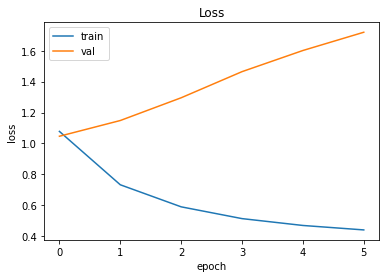

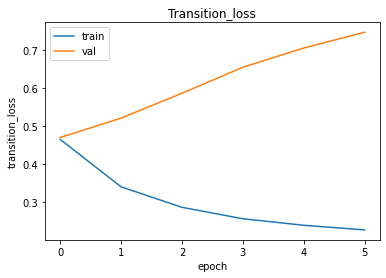

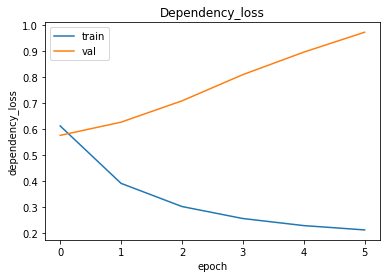

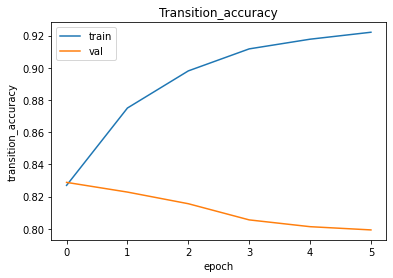

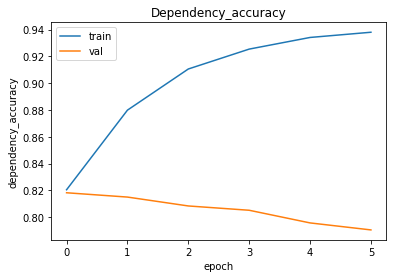

In [ ]:
set_random_seed(666)

my_parser = DependencyParser(language="en", n=2, debug=True)
my_parser.create_model(embeding_size=(8,8,8,8))
my_parser.train(epochs=10)
my_parser.evaluate()
my_parser.plot_history(["loss", "transition_loss", "dependency_loss", "transition_accuracy", "dependency_accuracy"])

## Example of inference using the DependencyParser

In [ ]:
samples = [
    [('Creative', 'PROPN'), ('Commons', 'PROPN'), ('provides', 'VERB'), ('this', 'DET'), ('information', 'NOUN'), ('on', 'ADP'), ('an', 'DET'), ('"', 'PUNCT'), ('as', 'ADP'), ('-', 'PUNCT'), ('is', 'VERB'), ('"', 'PUNCT'), ('basis', 'NOUN'), ('.', 'PUNCT')],
    [('Distribution', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('license', 'NOUN'), ('does', 'AUX'), ('not', 'PART'), ('create', 'VERB'), ('an', 'DET'), ('attorney', 'NOUN'), ('-', 'PUNCT'), ('client', 'NOUN'), ('relationship', 'NOUN'), ('.', 'PUNCT')],
    [('Economic', 'ADJ'), ('news', 'NOUN'), ('had', 'AUX'), ('little', 'ADJ'), ('effect', 'NOUN'), ('on', 'ADP'), ('financial', 'ADJ'), ('markets', 'NOUN'), ('.', 'PUNCT')],
    [('My', 'PRON'), ('teacher', 'NOUN'), ('Vilares', 'NOUN'), ('is', 'VERV'), ('a', 'DET'), ('very', 'ADV'), ('smart', 'ADJ'), ('person', 'NOUN'), (',', 'PUNCT'), ('he', 'PROUN'), ('teaches', 'VERB'), ('me', 'PROUN'), ('to', 'ADP'), ('train', 'VERB'), ('a', 'DET'), ('tagger', 'NOUN'), ('.', 'NOUN')]
]

my_parser.debug = False
dependencies = my_parser.predict(samples, show_prediction=True)




▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀
     1          2          3          4          5          6          7          8          9     
  Economic     news       had       little     effect       on     financial   markets       .     
     ↓          ↓          ↓          ↓          ↓          ↓          ↓          ↓          ↓     
    ADJ        NOUN       AUX        ADJ        NOUN       ADP        ADJ        NOUN      PUNCT   
0. (x) ROOT
	2. (root) news
		1. (amod) Economic
		3. (<unknown>) had
			5. (aux) effect
				4. (amod) little
				8. (nmod) markets
					7. (amod) financial
					6. (case) on
			9. (none) .


▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀▀
     1          2          3          4          5          6          7          8          9          10         11         12         13    
Distribution     o

## Example of well tagged phrases (for the first 2 predictions)

In [ ]:
a = ArcEager()
a.dependencies = [(3, 'nsubj', 1), (1, 'flat', 2), (0, 'root', 3), (5, 'det', 4), (3, 'obj', 5), (13, 'case', 6), (13, 'det', 7), (11, 'punct', 8), (11, 'mark', 9), (9, 'punct', 10), (13, 'amod', 11), (11, 'punct', 12), (3, 'obl', 13), (3, 'punct', 14)]
sample = [('Creative', 'PROPN'), ('Commons', 'PROPN'), ('provides', 'VERB'), ('this', 'DET'), ('information', 'NOUN'), ('on', 'ADP'), ('an', 'DET'), ('"', 'PUNCT'), ('as', 'ADP'), ('-', 'PUNCT'), ('is', 'VERB'), ('"', 'PUNCT'), ('basis', 'NOUN'), ('.', 'PUNCT')]
a.pretty_print(sample)

b = ArcEager()
b.dependencies = [(7, 'nsubj', 1), (4, 'case', 2), (4, 'det', 3), (1, 'nmod', 4), (7, 'aux', 5), (7, 'advmod', 6), (0, 'root', 7), (12, 'det', 8), (12, 'nmod', 9), (9, 'punct', 10), (9, 'compound', 11), (7, 'obj', 12), (7, 'punct', 13)]
sample = [('Distribution', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('license', 'NOUN'), ('does', 'AUX'), ('not', 'PART'), ('create', 'VERB'), ('an', 'DET'), ('attorney', 'NOUN'), ('-', 'PUNCT'), ('client', 'NOUN'), ('relationship', 'NOUN'), ('.', 'PUNCT')]
b.pretty_print(sample)

0. (x) ROOT
	3. (root) ('provides', 'VERB')
		1. (nsubj) ('Creative', 'PROPN')
			2. (flat) ('Commons', 'PROPN')
		5. (obj) ('information', 'NOUN')
			4. (det) ('this', 'DET')
		13. (obl) ('basis', 'NOUN')
			6. (case) ('on', 'ADP')
			7. (det) ('an', 'DET')
			11. (amod) ('is', 'VERB')
				8. (punct) ('"', 'PUNCT')
				9. (mark) ('as', 'ADP')
					10. (punct) ('-', 'PUNCT')
				12. (punct) ('"', 'PUNCT')
		14. (punct) ('.', 'PUNCT')
0. (x) ROOT
	7. (root) ('create', 'VERB')
		1. (nsubj) ('Distribution', 'NOUN')
			4. (nmod) ('license', 'NOUN')
				2. (case) ('of', 'ADP')
				3. (det) ('this', 'DET')
		5. (aux) ('does', 'AUX')
		6. (advmod) ('not', 'PART')
		12. (obj) ('relationship', 'NOUN')
			8. (det) ('an', 'DET')
			9. (nmod) ('attorney', 'NOUN')
				10. (punct) ('-', 'PUNCT')
				11. (compound) ('client', 'NOUN')
		13. (punct) ('.', 'PUNCT')


# Computing standard metrics for parsing (using conll18_ud_eval.py)

## Generate .conllu files (original an predicted)

In [ ]:
def join_info(samples, deps):
  result = []
  for sample, dep in zip(samples,deps):
    # start=1 because deps has the ROOT as 0
    dep_dict = {h:(p,r) for (p,r,h) in dep}
    result.append([(i, w, p, dep_dict[i][0], dep_dict[i][1]) for (i,(w,p)) in enumerate(sample,start=1)])
  return result

def to_conllu(data,file_name):
  f = open(file_name, "w")
  for sample in data:
    for (id,w,p,h,r) in sample:
      line = ["_" for _ in range (10)]
      line[0] = str(id)
      line[1] = w
      line[3] = p
      line[6] = str(h)
      line[7] = r
      f.write("\t".join(line)+"\n")
    f.write("\n")
  f.close()

# Original
info = join_info(my_parser.raw_test_ds[0], my_parser.raw_test_ds[1])
to_conllu(info, "original.txt")

# Obtained
info = join_info(my_parser.raw_test_ds[0], my_parser.predict(my_parser.raw_test_ds[0]))
to_conllu(info, "obtained.txt")
#!cat obtained.txt

In [ ]:
print(len(my_parser.raw_train_ds[0]))
print(len(my_parser.raw_dev_ds[0]))
print(len(my_parser.raw_test_ds[0]))

1748
152
153


## Compute labelled (LAS) and unlabeled attachment scores (UAS)

In [ ]:
!wget https://universaldependencies.org/conll18/conll18_ud_eval.py

--2022-12-21 18:36:46--  https://universaldependencies.org/conll18/conll18_ud_eval.py
Resolving universaldependencies.org (universaldependencies.org)... 185.199.108.153, 185.199.109.153, 185.199.110.153, ...
Connecting to universaldependencies.org (universaldependencies.org)|185.199.108.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27773 (27K) [application/octet-stream]
Saving to: ‘conll18_ud_eval.py.4’

conll18_ud_eval.py. 100%[===================>]  27.12K  --.-KB/s    in 0s      

2022-12-21 18:36:46 (123 MB/s) - ‘conll18_ud_eval.py.4’ saved [27773/27773]



In [ ]:
!python3 conll18_ud_eval.py original.txt obtained.txt

LAS F1 Score: 57.34
MLAS Score: 43.03
BLEX Score: 44.64


In [ ]:
!python3 conll18_ud_eval.py original.txt obtained.txt --verbose

Metric     | Precision |    Recall |  F1 Score | AligndAcc
-----------+-----------+-----------+-----------+-----------
Tokens     |    100.00 |    100.00 |    100.00 |
Sentences  |    100.00 |    100.00 |    100.00 |
Words      |    100.00 |    100.00 |    100.00 |
UPOS       |    100.00 |    100.00 |    100.00 |    100.00
XPOS       |    100.00 |    100.00 |    100.00 |    100.00
UFeats     |    100.00 |    100.00 |    100.00 |    100.00
AllTags    |    100.00 |    100.00 |    100.00 |    100.00
Lemmas     |    100.00 |    100.00 |    100.00 |    100.00
UAS        |     67.02 |     67.02 |     67.02 |     67.02
LAS        |     57.34 |     57.34 |     57.34 |     57.34
CLAS       |     47.64 |     42.00 |     44.64 |     42.00
MLAS       |     45.92 |     40.48 |     43.03 |     40.48
BLEX       |     47.64 |     42.00 |     44.64 |     42.00
